In [40]:
#!/usr/bin/env python    

## Author: Enda Carroll
## Date: Sept 2021
## Info: Script to compare solver results with decaying turbulence papers
#        Solver data

#######################
##  Library Imports  ##
#######################
import numpy as np
import h5py
import sys
import os
from numba import njit
import matplotlib as mpl
import matplotlib as mpl
if mpl.__version__ > '2':
    mpl.rcParams['text.usetex'] = True
    mpl.rcParams['font.family'] = 'serif'
    mpl.rcParams['font.serif']  = 'Computer Modern Roman'
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1 import make_axes_locatable
import getopt
import numba
from itertools import zip_longest
import multiprocessing as mprocs
import time as TIME
from subprocess import Popen, PIPE, run
from matplotlib.pyplot import cm
from functions import tc, sim_data, import_data, import_spectra_data, import_post_processing_data, import_sys_msr, energy_spectrum, enstrophy_spectrum
from plot_functions import plot_flow_summary

In [41]:
in_dir = "/home/enda/PhD/2D-Navier-Stokes/Data/Working/SIM_DATA_NAVIER_AB4CN_FULL_N[256,256]_T[0.0,0.001,500.000]_NU[5e-15,1,4.0]_DRAG[0.1,1,0.0]_CFL[0.90]_FORC[BODY_FORC,2,1]_u0[RANDOM]_TAG[Body-Force-Test]/"
out_dir = in_dir

In [42]:
%%time

# -----------------------------------------
# # --------  Read In data
# -----------------------------------------
## Read in simulation parameters
sys_vars = sim_data(in_dir)

## Read in solver data
run_data = import_data(in_dir, sys_vars)

## Read in system measures
sys_msr_data = import_sys_msr(in_dir, sys_vars)

## Read in spectra data
spec_data = import_spectra_data(in_dir, sys_vars)

CPU times: user 7.52 s, sys: 6.39 s, total: 13.9 s
Wall time: 29.9 s


In [43]:
snaps_output_dir = out_dir + "RUN_SNAPS/"
if os.path.isdir(snaps_output_dir) != True:
    print("Making folder:" + tc.C + " RUN_SNAPS/" + tc.Rst)
    os.mkdir(snaps_output_dir)
vid_snaps_output_dir = out_dir + "VID_SNAPS/"
if os.path.isdir(vid_snaps_output_dir) != True:
    print("Making folder:" + tc.C + " VID_SNAPS/" + tc.Rst)
    os.mkdir(vid_snaps_output_dir)

# Function Definitions

In [44]:
@njit
def enst_spec(w_h, kx, ky):
    
    Ny = w_h.shape[0]
    Nx = Ny
    Nf = w_h.shape[1]
    
    spec_size = int(np.round(np.sqrt((Nx/2)**2 + (Nx/2)**2)) + 1)
                    
    enst_spec = np.zeros((spec_size))
    for i in range(Ny):
        for j in range(Nf):
            k_sqrt = int(np.sqrt(kx[j]**2 + ky[i]**2))
            
            if j == 0 or j == Nf - 1:
                enst_spec[k_sqrt] += np.absolute(w_h[i, j])**2
            else:
                enst_spec[k_sqrt] += 2.0 * np.absolute(w_h[i, j])**2
                    
    return enst_spec

@njit
def energy_density(u_h, v_h):
    
    Ny = u_h.shape[0]
    Nx = Ny
    Nf = u_h.shape[1]
    
    # spec_size = int(np.round(np.sqrt((Ny/2)**2 + (Nx/2)**2)) + 1)
                    
    enrg_density = np.zeros((Ny, Nf))
    for i in range(Ny):
        for j in range(Nf):
            
            enrg_density[i, j] = (np.absolute(u_h[i, j])**2 + np.absolute(v_h[i, j])**2) * 0.5 * 2.0 * (np.pi)**2 / (2.0 * np.pi)**2
                    
    return enrg_density

@njit
def enrg_spec(w_h, kx, ky):
    
    Ny = w_h.shape[0]
    Nx = Ny
    Nf = w_h.shape[1]
    
    spec_size = int(np.round(np.sqrt((Nx/2)**2 + (Nx/2)**2)) + 1)
                    
    enrg_spec = np.zeros((spec_size))
    for i in range(Ny):
        for j in range(Nf):
            k_sqrt = int(np.sqrt(kx[j]**2 + ky[i]**2))
            
            if j == 0 or j == Nf - 1:
                enrg_spec[k_sqrt] += np.absolute(w_h[i, j])**2
            else:
                enrg_spec[k_sqrt] += 2.0 * np.absolute(w_h[i, j])**2
                    
    return enrg_spec


In [45]:
spec_size = int(np.round(np.sqrt((sys_vars.Nx/2)**2 + (sys_vars.Nx/2)**2)) + 1)

In [38]:
u_hat = np.ones((sys_vars.ndata, sys_vars.Ny, sys_vars.Nx//2 + 1)) * 1j
v_hat = np.ones((sys_vars.ndata, sys_vars.Ny, sys_vars.Nx//2 + 1)) * 1j

for i in range(sys_vars.Ny):
    for j in range(sys_vars.Nx//2 + 1):
        
        k_sqr = (sys_msr_data.kx[j] ** 2 + sys_msr_data.ky[i] ** 2)
        
        if sys_msr_data.kx[j] == 0.0 and sys_msr_data.ky[i] == 0.0 or k_sqr == 0.0:
            u_hat[:, i, j] = 0.0 + 0.0*1j
            v_hat[:, i, j] = 0.0 + 0.0*1j
        else:
            ## Compute prefactor
            k_sqr_inv = 1j / k_sqr            

            ## Compute Fourier velocities
            u_hat[:, i, j] = sys_msr_data.ky[i] * k_sqr * run_data.w_hat[:, i, j]
            v_hat[:, i, j] = -sys_msr_data.kx[j] * k_sqr * run_data.w_hat[:, i, j]

In [43]:
enrg_density_field = energy_density(u_hat[0, :, :], v_hat[0, :, :])

In [32]:
len(run_data.ky)
len(run_data.kx)

1024

In [ ]:
%%time

##------------------------ Time Averaged Spectra to Measure the Spectra Scaling Exponent
k_range = np.arange(1, int(sys_vars.Nx/3))
mean_enrg_spec = np.mean(spec_data.enrg_spectrum[:, 1:int(sys_vars.Nx/3)], axis = 0)
mean_enst_spec = np.mean(spec_data.enst_spectrum[:, 1:int(sys_vars.Nx/3)], axis = 0)
p_enrg = np.polyfit(np.log(k_range[9:21]), np.log(mean_enrg_spec[9:21]), 1)
p_enst = np.polyfit(np.log(k_range[9:21]), np.log(mean_enst_spec[9:21]), 1)

mean_enrg_spec_py = np.zeros((spec_size))
mean_enst_spec_py = np.zeros((spec_size))
mean_enrg_spec_density_py = np.zeros((spec_size))
print(mean_enst_spec_py.shape)
for t in range(sys_vars.ndata):
    # enrg_spec_tmp, = energy_spectrum(run_data.w_hat[t, :, :], run_data.kx, run_data.ky, sys_vars.Nx, sys_vars.Ny)
    # enst_spec_tmp  = enstrophy_spectrum(run_data.w_hat[t, :, :], sys_msr_data.kx, sys_msr_data.ky, sys_vars.Nx, sys_vars.Ny)
    enst_spec_tmp  = enst_spec(run_data.w_hat[t, :, :], sys_msr_data.kx, sys_msr_data.ky)
    energy_density_field = energy_density(u_hat[t, :, :], v_hat[t, :, :])
    tmp_enrg_density_spec = enst_spec(energy_density_field, sys_msr_data.kx, sys_msr_data.ky)
    # mean_enrg_spec_py += enrg_spec_tmp
    mean_enst_spec_py += enst_spec_tmp
    mean_enrg_spec_density_py += tmp_enrg_density_spec
mean_enrg_spec_py /= sys_vars.ndata
mean_enst_spec_py /= sys_vars.ndata
mean_enrg_spec_density_py /= sys_vars.ndata

(725,)


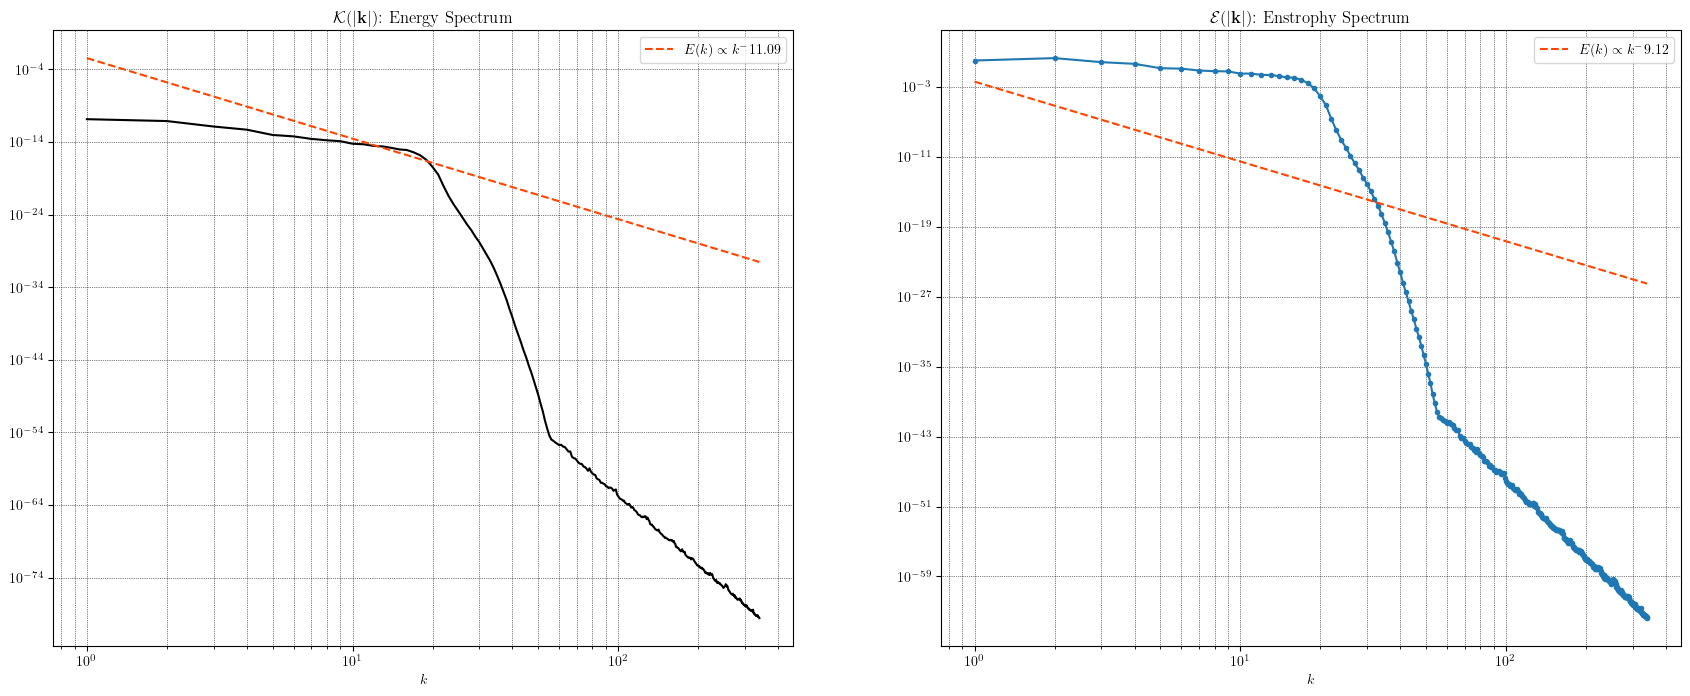

In [22]:

fig = plt.figure(figsize = (21, 8))
gs  = GridSpec(1, 2)
ax2 = fig.add_subplot(gs[0, 0])
ax2.plot(k_range, mean_enrg_spec, 'k')
# ax2.plot(k_range, mean_enrg_spec_py, '.-')
ax2.plot(k_range, np.exp(p_enrg[1]) * k_range**p_enrg[0], '--', color='orangered',label="$E(k) \propto k^{:.2f}$".format(p_enrg[0])) ## \Rightarrow \propto$ k^{-(3 + \qi)} \Rightarrow \qi = {:.2f} , np.absolute(np.absolute(p_enrg[0]) - 3))
ax2.set_xlabel(r"$k$")
ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.legend()
ax2.grid(which = "both", axis = "both", color = 'k', linestyle = ":", linewidth = 0.5)
ax2.set_title(r"$\mathcal{K}(|\mathbf{k}|)$: Energy Spectrum")

ax2 = fig.add_subplot(gs[0, 1])
# ax2.plot(k_range, mean_enst_spec, 'k')
ax2.plot(k_range, mean_enst_spec_py[1: int(sys_vars.Nx//3)], '.-')
ax2.plot(k_range, np.exp(p_enst[1]) * k_range**p_enst[0], '--', color='orangered',label="$E(k) \propto k^{:.2f}$".format(p_enst[0])) ## \propto$ k^{-(1 + \qi)} \Rightarrow , \qi = {:.2f} np.absolute(np.absolute(p_enst[0]) - 3))
ax2.set_xlabel(r"$k$")
ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.legend()
ax2.grid(which = "both", axis = "both", color = 'k', linestyle = ":", linewidth = 0.5)
ax2.set_title(r"$\mathcal{E}(|\mathbf{k}|)$: Enstrophy Spectrum")

plt.show()

In [56]:
k_range = np.arange(1, int(sys_vars.Nx/3))
inert_range = np.arange(9,31)
mean_enrg_spec = np.mean(spec_data.enrg_spectrum[:, 1:int(sys_vars.Nx/3)], axis = 0)
mean_enst_spec = np.mean(spec_data.enst_spectrum[:, 1:int(sys_vars.Nx/3)], axis = 0)
p_enrg = np.polyfit(np.log(k_range[inert_range]), np.log(mean_enrg_spec[inert_range]), 1)
p_enst = np.polyfit(np.log(k_range[inert_range]), np.log(mean_enst_spec[inert_range]), 1)
print(k_range, k_range[inert_range])

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72
 73 74 75 76 77 78 79 80 81 82 83 84] [10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31]


In [61]:
k_range_1024 = np.arange(1, int(1024/3))
inert_range_1024 = np.arange(9, 200)
print(k_range_1024[inert_range_1024])

[ 10  11  12  13  14  15  16  17  18  19  20  21  22  23  24  25  26  27
  28  29  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45
  46  47  48  49  50  51  52  53  54  55  56  57  58  59  60  61  62  63
  64  65  66  67  68  69  70  71  72  73  74  75  76  77  78  79  80  81
  82  83  84  85  86  87  88  89  90  91  92  93  94  95  96  97  98  99
 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117
 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135
 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153
 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171
 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189
 190 191 192 193 194 195 196 197 198 199 200]


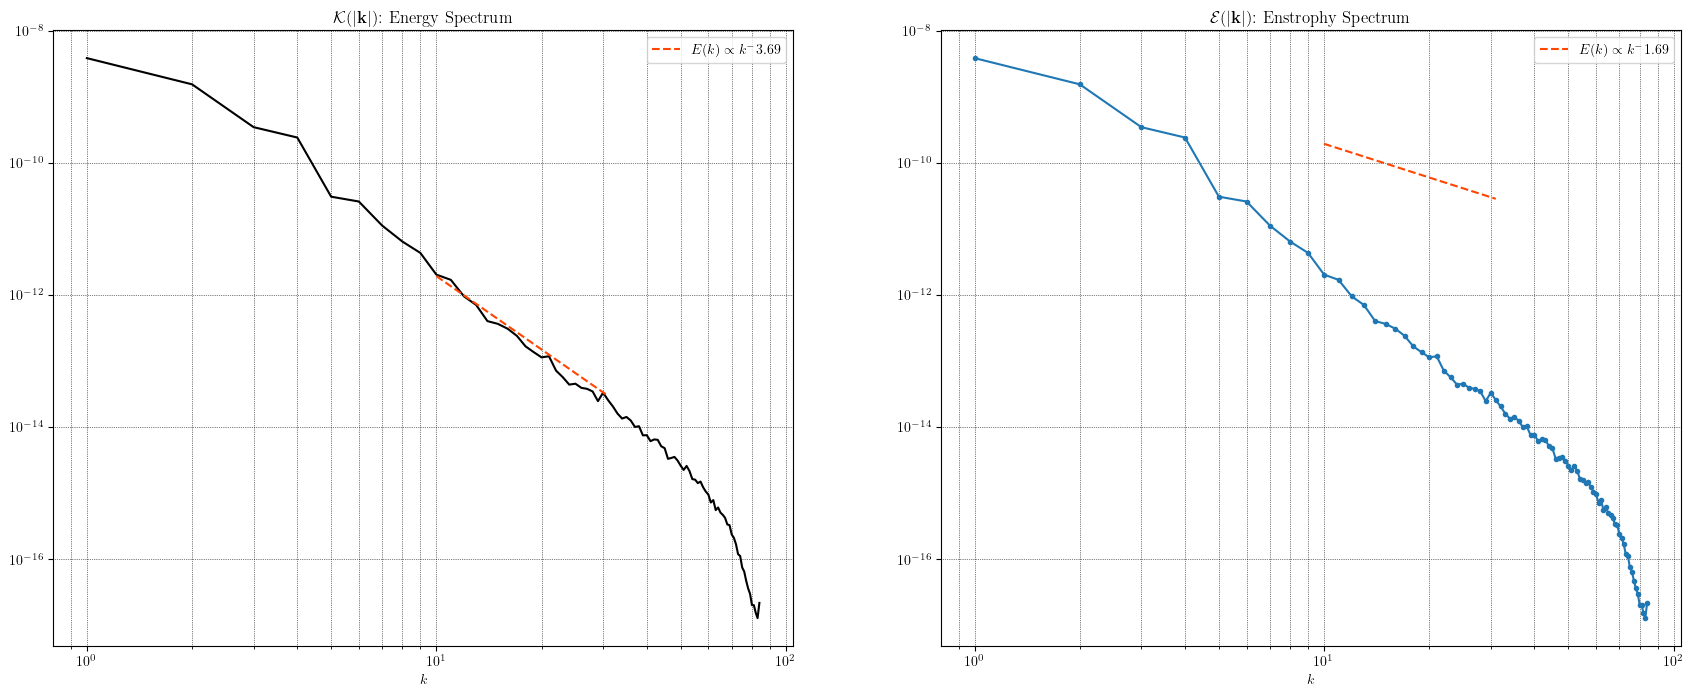

In [58]:
fig = plt.figure(figsize = (21, 8))
gs  = GridSpec(1, 2)
ax2 = fig.add_subplot(gs[0, 0])
ax2.plot(k_range, spec_data.enrg_spectrum[-1, 1:int(sys_vars.Nx/3)], 'k')
# ax2.plot(k_range, mean_enrg_spec_py, '.-')
ax2.plot(k_range[inert_range], np.exp(p_enrg[1]) * k_range[inert_range]**p_enrg[0], '--', color='orangered',label="$E(k) \propto k^{:.2f}$".format(p_enrg[0])) ## \Rightarrow \propto$ k^{-(3 + \qi)} \Rightarrow \qi = {:.2f} , np.absolute(np.absolute(p_enrg[0]) - 3))
ax2.set_xlabel(r"$k$")
ax2.set_xscale('log')
ax2.set_yscale('log')
# ax2.set_ylim(10e-17, 10e-5)
ax2.legend()
ax2.grid(which = "both", axis = "both", color = 'k', linestyle = ":", linewidth = 0.5)
ax2.set_title(r"$\mathcal{K}(|\mathbf{k}|)$: Energy Spectrum")

ax2 = fig.add_subplot(gs[0, 1])
# ax2.plot(k_range, mean_enst_spec, 'k')
ax2.plot(k_range, spec_data.enrg_spectrum[-1, 1:int(sys_vars.Nx/3)], '.-')
ax2.plot(k_range[inert_range], np.exp(p_enst[1]) * k_range[inert_range]**p_enst[0], '--', color='orangered',label="$E(k) \propto k^{:.2f}$".format(p_enst[0])) ## \propto$ k^{-(1 + \qi)} \Rightarrow , \qi = {:.2f} np.absolute(np.absolute(p_enst[0]) - 3))
ax2.set_xlabel(r"$k$")
ax2.set_xscale('log')
ax2.set_yscale('log')
# ax2.set_ylim(10e-19, 10e-2)
ax2.legend()
ax2.grid(which = "both", axis = "both", color = 'k', linestyle = ":", linewidth = 0.5)
ax2.set_title(r"$\mathcal{E}(|\mathbf{k}|)$: Enstrophy Spectrum")

plt.show()

In [38]:
n = 4
nu = 15e-20
nu_eps = 6.175e-05

l = np.power(nu / (nu_eps**(1/3)), 1 / (2 * n - 2/3))
print(l)

0.0042115119474135715


In [39]:
kk = 2.0 * np.pi / l
print(kk / 5)

298.3814547190492
